# Analytical solution for a beam under a uniform load

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_solid_mechanics/blob/main/notebooks/beam_analytic_uniform_load.ipynb).

This notebook was developed based on the Chapter 4 of the book [Teoría de la elasticidad usando Matlab y Maxima. Volumen 1: Fundamentos](https://repositorio.unal.edu.co/handle/unal/84682) by Álvarez Marín (2023).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

<div style="background-color: white; padding: 10px;">
    <img src="../figs/Beam_uniform_load.svg" height="300" frameborder="0" ></iframe>
</div>


## Required modules and global setup for plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sym
from ipywidgets import widgets as wgt
from ipywidgets import interact, widgets, FloatSlider, FloatText, fixed
from IPython import get_ipython
from IPython.display import display, clear_output

if 'google.colab' in str(get_ipython()):
    %pip install ipympl &> ~/pip-log.txt
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget
# %matplotlib inline

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'

## Functions

In [2]:
def beam_stress_fields(x, y, q, c, l):
    moi = (2 / 3) * c**3 # Second moment of inertia
    # Stress field
    𝜎_xx = - (x**2*y - 2*y**3/3 + 2*c**2*y/5 - l**2*y) * q / (2*moi)
    𝜎_yy = -(y**3/3 - c**2*y - 2*c**3/3) * q / (2*moi)
    𝜎_zz, 𝜏_xz, 𝜏_xyz = 0*𝜎_xx, 0*𝜎_xx, 0*𝜎_xx
    𝜏_xy = -(c**2 - y**2) * x * q / (2*moi)
    # Mean stress and max shear stress
    𝜎_m = (𝜎_xx + 𝜎_yy) / 2
    𝜏_max = np.sqrt(((𝜎_xx - 𝜎_yy) / 2) ** 2 + 𝜏_xy ** 2)
    #Principal stresses
    𝜎_1 = 𝜎_m + 𝜏_max
    𝜎_3 = 𝜎_m - 𝜏_max
    # return 𝜎_xx , 𝜎_yy , 𝜏_xy , 𝜎_1 , 𝜎_3 , 𝜎_m, 𝜏_max
    stress_fields = {
        "𝜎_xx": 𝜎_xx,
        "𝜎_yy": 𝜎_yy,
        "𝜏_xy": 𝜏_xy,
        "𝜎_1": 𝜎_1,
        "𝜎_3": 𝜎_3,
        "𝜎_m": 𝜎_m,
        "𝜏_max": 𝜏_max,
    }
    return stress_fields

def beam_strains_fields(x, y, q, c, l, E, ν):
    E *= 1e9 # Convert to [Pa]
    q *= 1e3 # Convert to [N/m]
    stress_fields = beam_stress_fields(x, y, q, c, l)
    𝜎_xx, 𝜎_yy, 𝜏_xy = stress_fields["𝜎_xx"], stress_fields["𝜎_yy"], stress_fields["𝜏_xy"]
    G = E / (2 * (1 + ν))  # Shear modulus
    # Strain field
    𝜀_xx = (𝜎_xx - ν*𝜎_yy) / E
    𝜀_yy = (𝜎_yy - ν*𝜎_xx) / E
    𝜀_zz  = -ν*(𝜎_xx + 𝜎_yy) / E
    𝛾_xy = 𝜏_xy / G
    𝜀_xy = 0.5 * 𝛾_xy
    # Mean strain and max shear stress
    𝜀_m = 0.5 * (𝜀_xx + 𝜀_yy)
    𝜀_max = np.sqrt((𝜀_xx - c) ** 2 + 𝜀_xy**2)
    #Principal strains
    𝜀_1 = 𝜀_m + 𝜀_max
    𝜀_3 = 𝜀_m - 𝜀_max
    strain_state = {
        "𝜀_xx": 𝜀_xx,
        "𝜀_yy": 𝜀_yy,
        "𝜀_zz": 𝜀_zz,
        "𝜀_xy": 𝜀_xy,
        "𝜀_1": 𝜀_1,
        "𝜀_3": 𝜀_3,
        "𝜀_vol": (𝜀_1 + 𝜀_3),
        "𝜀_max": 𝜀_max,
        "𝜀_m": 𝜀_m
    }
    return strain_state

def dict_values_to_numpy(dictionary):
    return np.array(list(dictionary.values()))

def round_dict(dictionary, decimals=2):
    return {key: np.round(val, decimals) for key, val in dictionary.items()}

def stress_at_a_value(x, y, q, c, l, field):
    stress = beam_stress_fields(x, y, q, c, l)[field]
    print(f'{field} at ({x}, {y}) is {stress:.2f} kPa')
    return

def strain_at_a_value(x, y, q, c, l, E, ν, field):
    strain = beam_strains_fields(x, y, q, c, l, E, ν)[field]
    print(f'{field} at ({x}, {y}) is {strain:.3E}')
    return

def plot_field(x, y, fields, **kwargs):
    figsize = kwargs.get('figsize')
    # Figure
    fields = fields if isinstance(fields, list) else [fields]
    titles = kwargs.get('titles')
    if titles is None:
        titles = [f'Field {i}' for i in range(len(fields))]
    else:
        titles = titles if isinstance(titles, list) else [titles]
    fig, axs = plt.subplots(ncols=1, nrows=len(fields), figsize=figsize,
                            sharex=True, sharey=True, constrained_layout=True)
    axs = axs if len(fields)>1 else [axs]
    for ax, field, title in zip(axs, fields, titles):
        im = ax.contourf(x, y, field, cmap="RdYlBu_r", origin='image', levels=15)
        ax.axis('image')
        ax.set_title(title)
        # if 'cbar_fmt' in kwargs:
        cb = fig.colorbar(im, ax=ax, shrink=0.75, aspect=5, location='left',
                            format=kwargs.get('cbar_fmt'))
        # else:
        #     cb = fig.colorbar(im, ax=ax, shrink=0.75, aspect=5, location='left')
        cb.ax.set_ylabel(kwargs.get('units'), rotation=90)
    display(wgt.HTML(html_setup))
    plt.close()
    return fig

## Global inputs

In [3]:
# Input data - Beam geometry and load
q = -10  # [kN/m]
c = 0.5  # [m]
l = 3  # [m]
t = 1  # [m]
E = 21  # [GPa]
ν = 0.23  # [-]

## Stresses

### Tensor components at one point

In [4]:
wid = interact(  # Interactive widgets
    stress_at_a_value,
    x = wgt.BoundedFloatText(value=1, min=-l, max=l, step=0.5, description='x [m]:'),
    y = wgt.BoundedFloatText(value=-0.3, min=-c, max=c, step=0.1, description='y [m]'),
    q = wgt.FloatText(value=q, description='load [kN/m]:'),
    c = wgt. BoundedFloatText(value=c, min=0.01, step=0.5, description='h [m]:'),
    l = wgt. BoundedFloatText(value=l, min=0.01, step=0.5, description='l [m]:'),
    field = wgt.Dropdown(options=['𝜎_xx', '𝜎_yy', '𝜏_xy', '𝜎_1', '𝜎_3', '𝜎_m', '𝜏_max'],
        value='𝜏_max', description='field:'),
)

interactive(children=(BoundedFloatText(value=1.0, description='x [m]:', max=3.0, min=-3.0, step=0.5), BoundedF…

### Plotting the fields

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

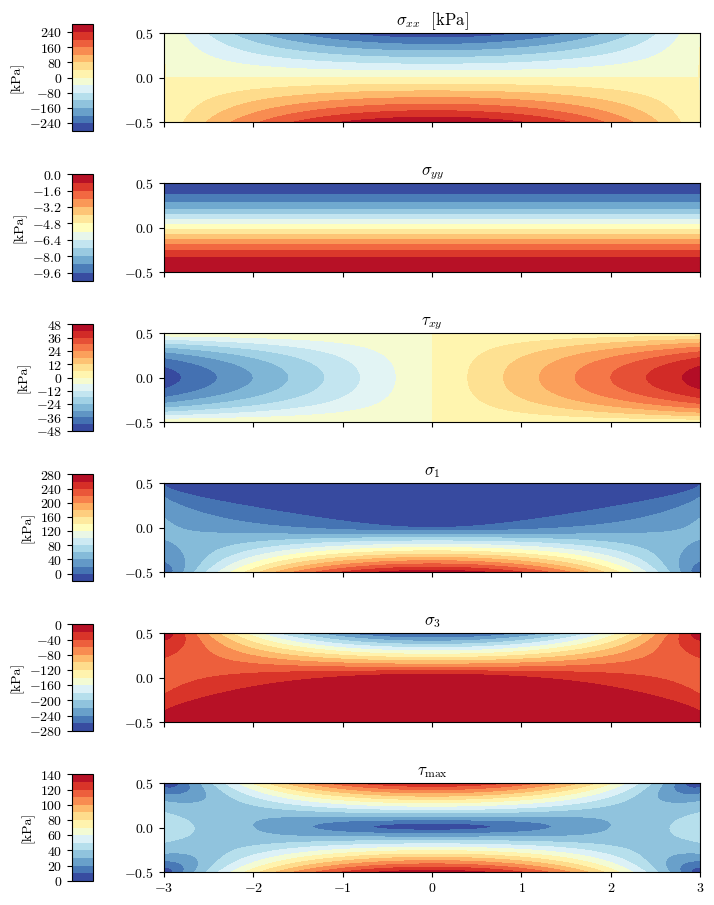

In [5]:
# Nodes
xx , yy = np.meshgrid(np.linspace(-l , l , 100), np.linspace(-c, c, 100))

# Solver
stress_fields = beam_stress_fields(xx , yy, q, c, l)
𝜎_xx , 𝜎_yy , 𝜏_xy , 𝜎_1 , 𝜎_3 , 𝜎_m, 𝜏_max = stress_fields.values()

# Visualization
titles = ["$\sigma_{xx}$  [kPa]", "$\sigma_{yy}$", "$\\tau_{xy}$", "$\sigma_{1}$", "$\sigma_{3}$", "$\\tau_\mathrm{max}$"]
plot_field(xx , yy, [𝜎_xx , 𝜎_yy , 𝜏_xy , 𝜎_1 , 𝜎_3 , 𝜏_max], units='[kPa]', titles=titles, figsize=[7, 9])

## Strains

### Tensor components at one point

In [6]:
wid = interact(  # Interactive widgets
    strain_at_a_value,
    x = wgt.BoundedFloatText(value=1, min=-l, max=l, step=0.5, description='x [m]:'),
    y = wgt.BoundedFloatText(value=-0.3, min=-c, max=c, step=0.1, description='y [m]'),
    q = wgt.FloatText(value=q, description='load [kN/m]:'),
    c = wgt. BoundedFloatText(value=c, min=0.01, step=0.5, description='h [m]:'),
    l = wgt. BoundedFloatText(value=l, min=0.01, step=0.5, description='l [m]:'),
    E = wgt. BoundedFloatText(value=E, min=1, step=1, description='E [GPa]:'),
    ν = wgt. BoundedFloatText(value=ν, min=0.01, step=0.01, description='ν [-]:'),
    field = wgt.Dropdown(options=['𝜀_xx', '𝜀_yy', '𝜀_zz', '𝜀_xy', '𝜀_vol'],
        value='𝜀_xy', description='field:'),
)

interactive(children=(BoundedFloatText(value=1.0, description='x [m]:', max=3.0, min=-3.0, step=0.5), BoundedF…

### Plotting the fields

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

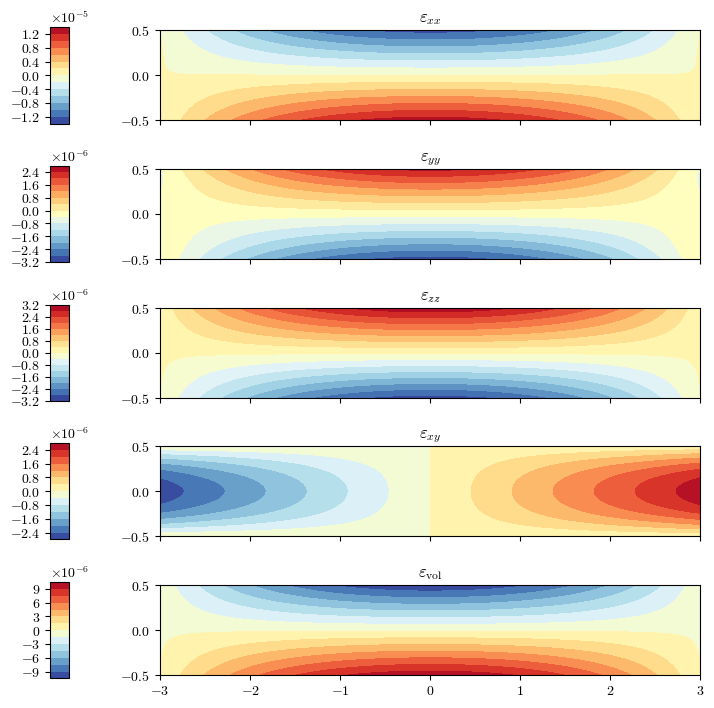

In [7]:
# Nodes
xx , yy = np.meshgrid(np.linspace(-l , l , 100), np.linspace(-c, c, 100))

# Solver
strain_fields = beam_strains_fields(xx , yy, q, c, l, E, ν)
𝜀_xx, 𝜀_yy, 𝜀_zz, 𝜀_xy, 𝜀_1, 𝜀_3, 𝜀_vol, 𝜀_max, 𝜀_m = strain_fields.values()

# Visualization
titles = ["$\\varepsilon_{xx}$", "$\\varepsilon_{yy}$", "$\\varepsilon_{zz}$", "$\\varepsilon_{xy}$",
          "$\\varepsilon_\mathrm{vol}$"]
plot_field(xx , yy, [𝜀_xx, 𝜀_yy, 𝜀_zz, 𝜀_xy, 𝜀_vol], titles=titles, figsize=[7, 7])

## Relating stresses fields to the shear force and bending moment diagrams

In [8]:
# Defining symbols
c_, q_, y_, x_, z_, t_, q_, L_, I_ = sym.symbols('c q y x z t q L I')

# Moment of inertia
I_ = 2*c_**3/3
# Thickness
t_ = 1

### Shear force

$
V(x) = \int\limits_{-c}^c \int\limits_{0}^t \tau_{xy}(x,y, z)\ \mathrm{d}z\ \mathrm{d}y  = qx 
$

In [9]:
# Shear stress
𝜏_xy_ = - (q_ / (2 * I_)) * (c_**2 - y_**2) * x_

# Shear force
Vx_ = -sym.integrate(sym.integrate(𝜏_xy_, (z_, 0, t_)), (y_, -c_, c_))
Vx_

q*x

### Bending moment

$
M(x) = \int\limits_{-c}^c \int\limits_{0}^t y \sigma_{xx}(x, y, z)\ \mathrm{d}z\ \mathrm{d}y   =  -\frac{q}{2} (L^2 - x^2)
$

In [10]:
# Stress in x-direction
𝜎_xx_ = -(q_ / (2 * I_)) * (x_**2*y_ - 2*y_**3/3 + 2*c_**2*y_/5 - L_**2*y_)
# Flexural moment
Mx = -sym.integrate(sym.integrate(y_*𝜎_xx_, (z_, 0, t_)), (y_, -c_, c_))
Mx

-L**2*q/2 + q*x**2/2